In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import activations
from tensorflow.keras import callbacks
from tensorflow.keras import Input
from tensorflow.keras import utils
from tensorflow.keras import backend as K
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
print('TensorFlow版本: {0}'.format(tf.__version__))


2.7.0


In [2]:
data = pd.read_csv('./data/TrainingSet.csv')
print(data.shape)
labels = data['QuantitySold']
data = data.drop(columns=['ReturnsAccepted', 'QuantitySold'])
columns = data.columns
print('特征个数: {0}'.format(len(columns)))
print(columns)
print('\n统计是否有缺失值')
for c in columns:
    print('{0}: {1}'.format(c, data[c].isnull().sum()))
embed_cols = ['EbayID', 'SellerName', 'Category', 'EndDay',]

(258588, 28)
特征个数: 26
Index(['EbayID', 'Price', 'PricePercent', 'StartingBidPercent', 'SellerName',
       'SellerClosePercent', 'Category', 'PersonID', 'StartingBid', 'AvgPrice',
       'EndDay', 'HitCount', 'AuctionAvgHitCount', 'ItemAuctionSellPercent',
       'SellerSaleAvgPriceRatio', 'SellerAvg', 'SellerItemAvg',
       'AuctionHitCountAvgRatio', 'BestOffer', 'IsHOF', 'ItemListedCount',
       'AuctionCount', 'AuctionSaleCount', 'SellerAuctionCount',
       'SellerAuctionSaleCount', 'AuctionMedianPrice'],
      dtype='object')

统计是否有缺失值
EbayID: 0
Price: 0
PricePercent: 0
StartingBidPercent: 0
SellerName: 0
SellerClosePercent: 0
Category: 0
PersonID: 0
StartingBid: 0
AvgPrice: 0
EndDay: 0
HitCount: 0
AuctionAvgHitCount: 0
ItemAuctionSellPercent: 0
SellerSaleAvgPriceRatio: 0
SellerAvg: 0
SellerItemAvg: 0
AuctionHitCountAvgRatio: 0
BestOffer: 0
IsHOF: 0
ItemListedCount: 0
AuctionCount: 0
AuctionSaleCount: 0
SellerAuctionCount: 0
SellerAuctionSaleCount: 0
AuctionMedianPrice: 0


In [3]:
seller_name = data[embed_cols[1]].values
end_day = data[embed_cols[3]].values
ebay_id = data[embed_cols[0]].values
category = data[embed_cols[2]].values

ei_emb = layers.experimental.preprocessing.IntegerLookup()
ei_emb.adapt(ebay_id)
ei_num = len(ei_emb.get_vocabulary())
print('EbayID个数: {0}'.format(ei_num))
cate_emb = layers.experimental.preprocessing.IntegerLookup()
cate_emb.adapt(category)
cate_num = len(cate_emb.get_vocabulary())
print('Category个数: {0}'.format(cate_num))
ed_emb = layers.experimental.preprocessing.StringLookup()
ed_emb.adapt(end_day)
ed_num = len(ed_emb.get_vocabulary())
print('EndDay个数: {0}'.format(ed_num))
sn_emb = layers.experimental.preprocessing.StringLookup()
sn_emb.adapt(seller_name)
sn_num = len(sn_emb.get_vocabulary())
print('SellerName个数: {0}'.format(sn_num))

EbayID个数: 258589
Category个数: 46
EndDay个数: 8
SellerName个数: 11067


In [4]:
data = data.drop(columns=embed_cols).values
print(data.shape)
print('数值特征归一化:')
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)
print(data)

(258588, 22)
数值特征归一化:
[[9.08060537e-02 8.21956643e-04 2.98499166e-05 ... 1.84181262e-03
  5.78922495e-03 5.09834605e-03]
 [1.43309554e-01 8.01667593e-04 1.86214564e-04 ... 3.64887406e-03
  1.22873346e-02 1.01717206e-02]
 [3.66357757e-02 3.31795442e-04 3.01612007e-04 ... 8.44453711e-03
  1.20510397e-02 5.09834605e-03]
 ...
 [1.32675512e-02 1.44958310e-03 1.44958310e-03 ... 2.64108980e-03
  2.83553875e-03 4.07867684e-04]
 [9.99399960e-02 1.37354086e-04 1.37354086e-04 ... 1.71323325e-02
  6.85255198e-03 2.01811265e-02]
 [4.16361091e-02 2.05947749e-04 4.92495831e-05 ... 5.97720322e-03
  1.90217391e-02 8.33007317e-03]]


In [5]:
class Squeeze(layers.Layer):
    def __init__(self, **kwargs):
        super(Squeeze, self).__init__(**kwargs)
    def call(self, inputs, *args, **kwargs):
        return K.squeeze(inputs, axis=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cate_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 endday_input (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 sellername_input (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 integer_lookup_1 (IntegerLooku  (None, 1)           0           ['cate_input[0][0]']             
 p)                                                                                           

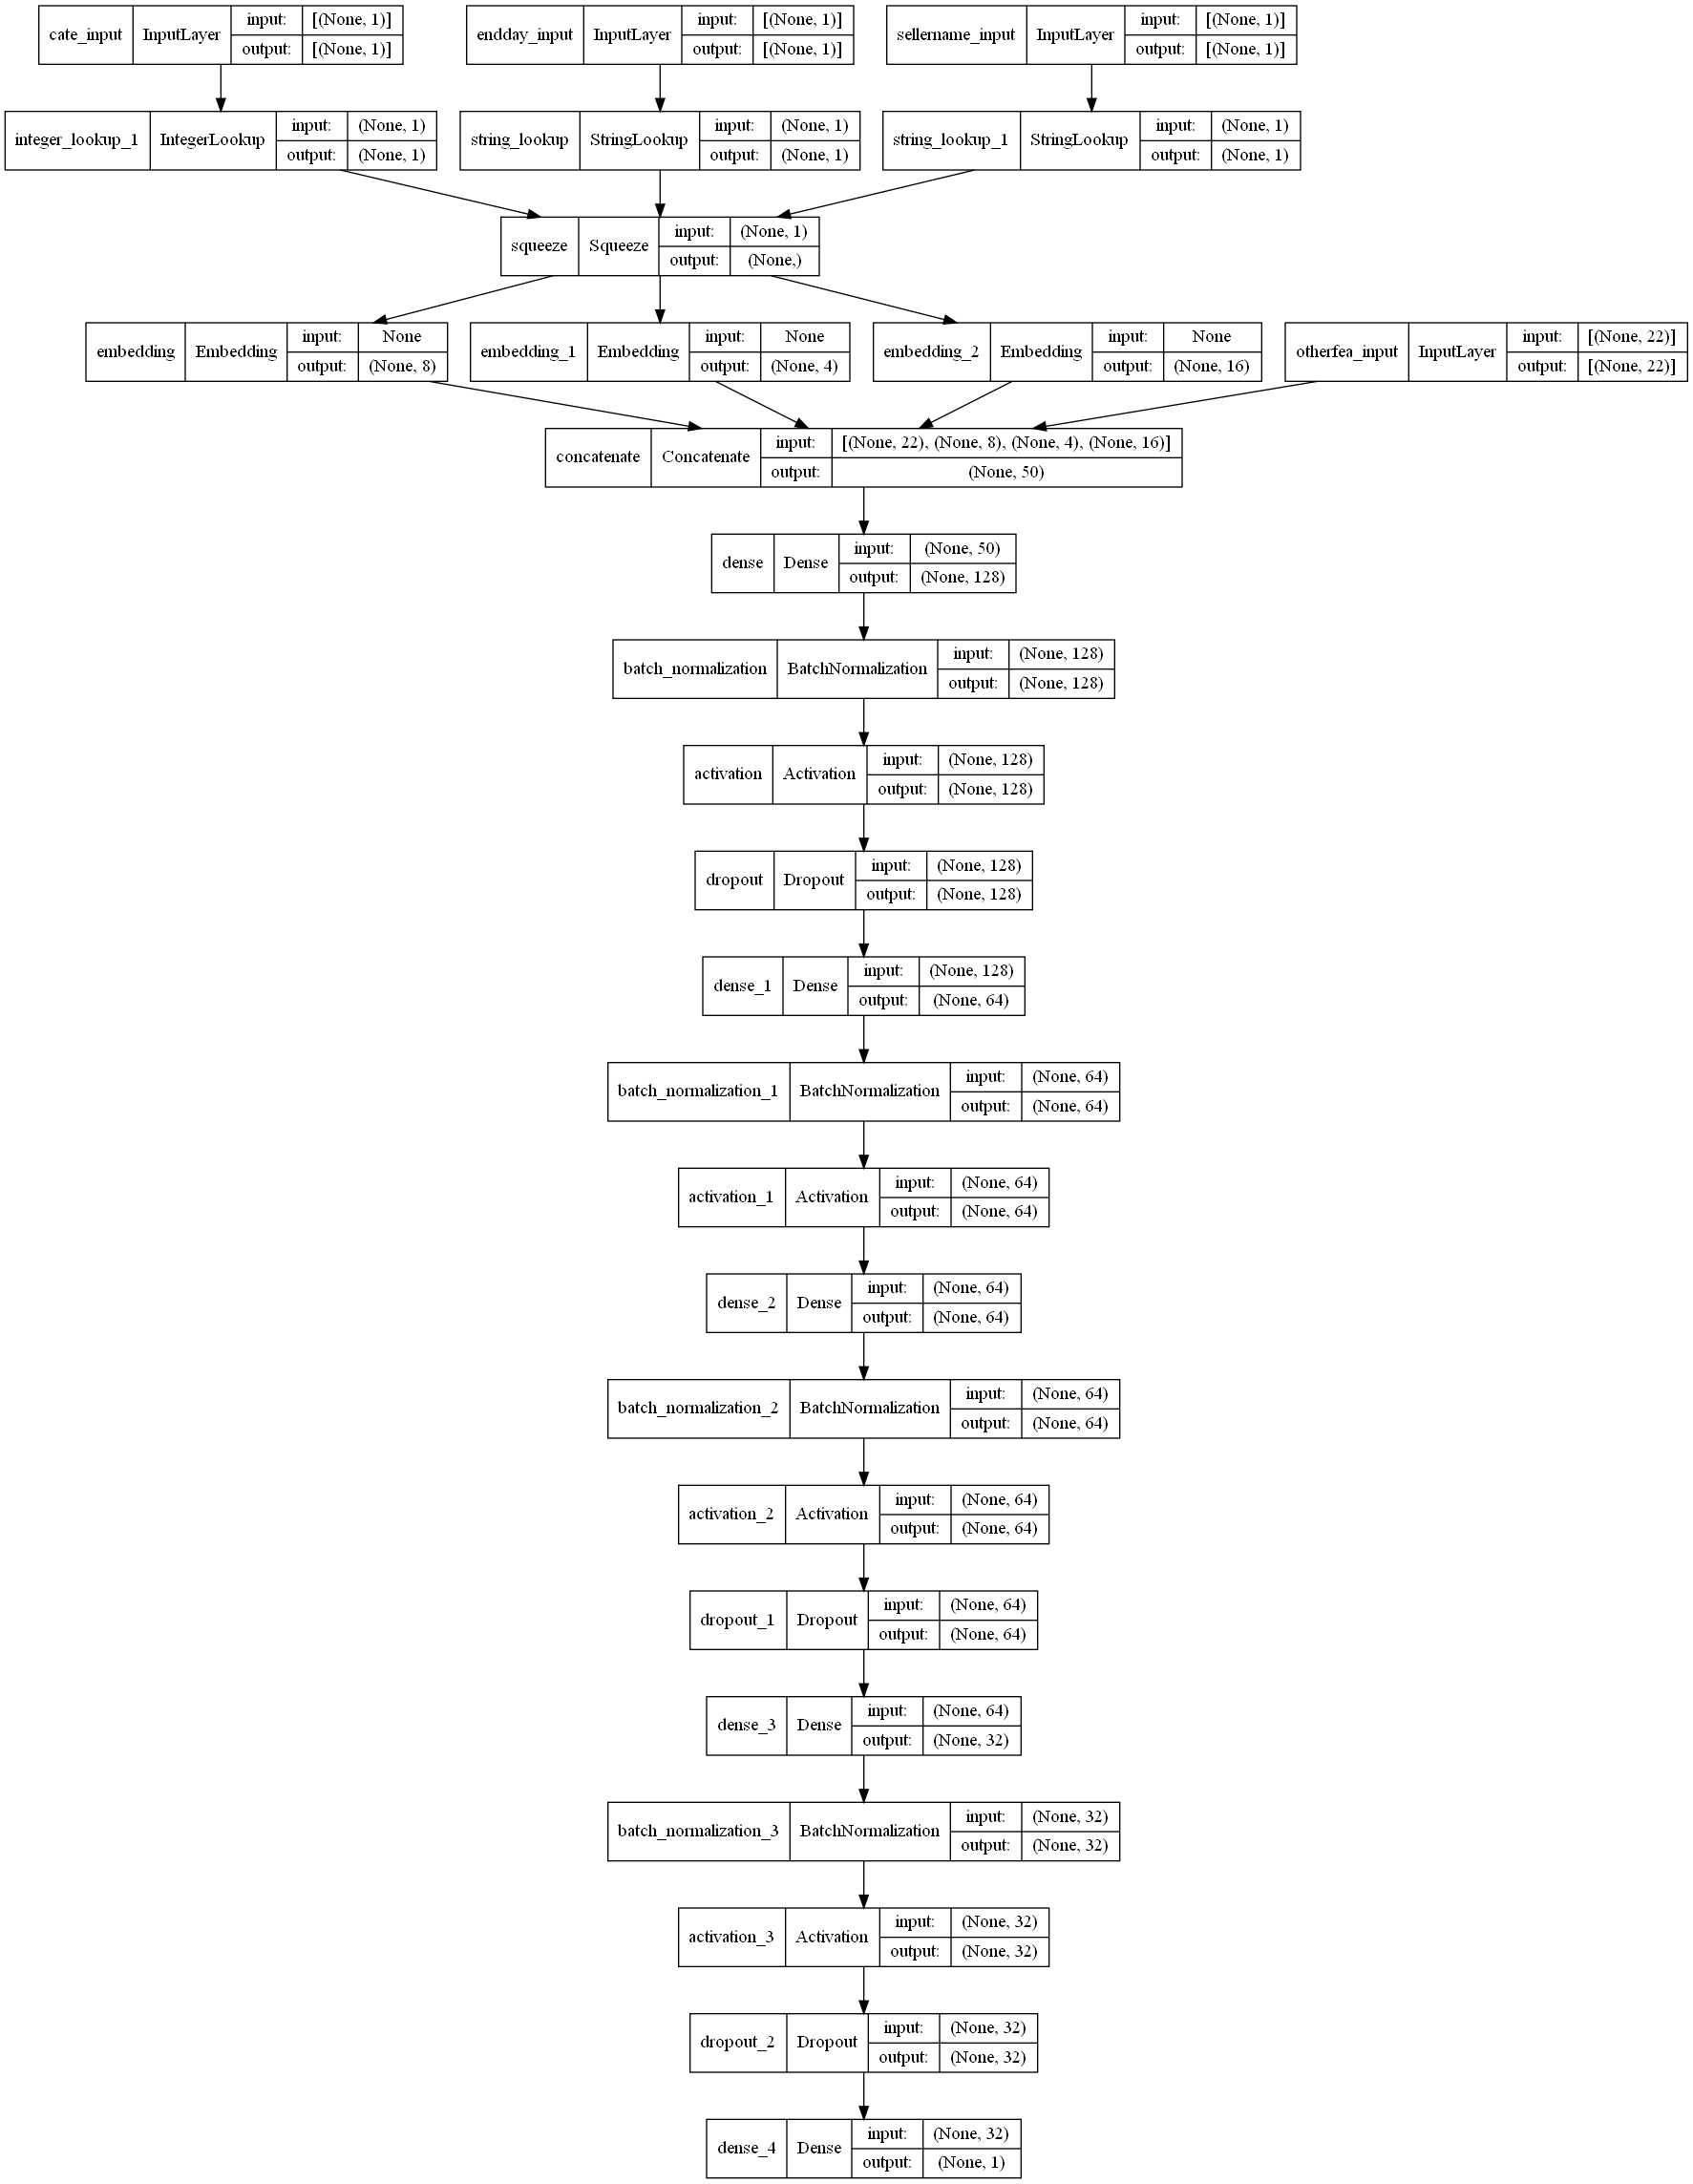

In [6]:
# ei_input = Input(shape=(1,), dtype='float32', name='ebayid_input')
cate_input = Input(shape=(1,), dtype='float32', name='cate_input')
ed_input = Input(shape=(1,), dtype='string', name='endday_input')
sn_input = Input(shape=(1,), dtype='string', name='sellername_input')

# ei_emb = ei_emb(ei_input)
cate_emb = cate_emb(cate_input)
ed_emb = ed_emb(ed_input)
sn_emb = sn_emb(sn_input)

# ei_emb = layers.Embedding(ei_num, 16)(ei_emb)
cate_emb = layers.Embedding(cate_num, 8)(cate_emb)
ed_emb = layers.Embedding(ed_num, 4)(ed_emb)
sn_emb = layers.Embedding(sn_num, 16)(sn_emb)

squeeze_layer = Squeeze()
cate_emb = squeeze_layer(cate_emb)
ed_emb = squeeze_layer(ed_emb)
sn_emb = squeeze_layer(sn_emb)

ox_input = layers.Input(shape=(data.shape[-1],), dtype='float32', name='otherfea_input')
x = layers.Concatenate()([ox_input, cate_emb, ed_emb, sn_emb])
x = layers.Dense(128, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activations.swish)(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activations.swish)(x)
x = layers.Dense(64, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activations.swish)(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation(activations.swish)(x)
x = layers.Dropout(0.2)(x)
output = layers.Dense(1, activation=activations.sigmoid)(x)

model = models.Model(inputs=[cate_input, ed_input, sn_input, ox_input], outputs=[output])
model.compile(loss=losses.BinaryCrossentropy(),
              optimizer=optimizers.Adam(),
              metrics=[metrics.BinaryAccuracy()])
print(model.summary())
utils.plot_model(model, './model.png', show_shapes=True)

In [ ]:
def make_dataset(cate, ed, sn, ox, label):
    ds = tf.data.Dataset.from_tensor_slices(((cate, ed, sn, ox), label))
    ds = ds.shuffle(1024, reshuffle_each_iteration=True)
    ds = ds.batch(256).cache().prefetch(tf.data.AUTOTUNE)
    return ds

In [ ]:
callback = [callbacks.EarlyStopping(monitor='val_acc', patience=8, restore_best_weights=True),
            callbacks.ReduceLROnPlateau(monitor='val_acc', patience=3, factor=0.65)]

In [ ]:
kfold = KFold(n_splits=5, random_state=43, shuffle=True)
for k, (train_ind, test_ind) in enumerate(kfold.split(data, labels)):
    train_cate = category[train_ind]
    train_ed = end_day[train_ind]
    train_sn = seller_name[train_ind]
    train_ox = data[train_ind]

    test_cate = category[test_ind]
    test_ed = end_day[test_ind]
    test_sn = seller_name[test_ind]
    test_ox = data[test_ind]




